In [41]:
import numpy as np
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [59]:
import numpy as np
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")


### Shape of data

In [33]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [34]:
idx = (person_train_valid==0)
idx = np.squeeze(idx)
X_train_valid[idx].shape

(237, 22, 1000)

# Preprocessing

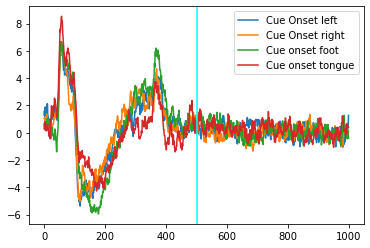

In [96]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.squeeze(np.load("person_train_valid.npy"))
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.squeeze(np.load("person_test.npy"))


## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:] # extracts the 9th channel from the data


class_0_ind = np.where(y_train_valid == 0) # finds the indices where the label is 0
ch_data_class_0 = ch_data[class_0_ind] # finds the data where label is 0
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0) # finds the average representation of the 9th channel when label is 0


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [97]:
print(person_train_valid.shape)
print(person_test.shape)

(2115,)
(443,)


In [98]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)

    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y




In [67]:
X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)
(2115,)
(2115,)


In [77]:
X_train_valid_prep,person_train_valid_prep = data_prep(X_train_valid,person_train_valid,2,2,True)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)
(2115,)
(8460,)
[0. 0. 0. ... 8. 8. 8.]


In [52]:
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


## Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)


print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)



# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of testing set: (1772, 22, 250)
Shape of testing labels: (1772, 64, 4)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversio

In [99]:
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(person_train, person_valid) = person_train_valid[ind_train], person_train_valid[ind_valid]


## Preprocessing the dataset
x_train,person_train = data_prep(X_train,person_train,2,2,True)
x_valid,person_valid = data_prep(X_valid,person_valid,2,2,True)
X_test_prep,person_test_prep = data_prep(X_test,person_test,2,2,True)


print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',person_test_prep.shape)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',person_train.shape)
print('Shape of validation labels:',person_valid.shape)



# Converting the labels to categorical variables for multiclass classification
person_train = to_categorical(person_train, 9)
person_valid = to_categorical(person_valid, 9)
person_test = to_categorical(person_test_prep, 9)
print('Shape of training labels after categorical conversion:',person_train.shape)
print('Shape of validation labels after categorical conversion:',person_valid.shape)
print('Shape of test labels after categorical conversion:',person_test_prep.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of testing set: (1772, 22, 250)
Shape of testing labels: (1772,)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of training labels after categorical conversion: (6960, 9)
Shape of validation labels after categorical conversion: (15

In [100]:
print(person_test.shape)

(1772, 9)


# Model

# Hyperparameter

In [84]:
# Model parameters
learning_rate = 1e-3
epochs = 50
cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [88]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(9, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 84, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 84, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_16 (Dropout)        (None, 84, 1, 25)         0         
                                                                 
 conv2d_58 (Conv2D)          (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 28, 1, 50)      

In [90]:
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

In [91]:
basic_cnn_model_results = basic_cnn_model.fit(x_train,
             person_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, person_valid), verbose=True)

Epoch 1/50
109/109 [==============================] - 3s 25ms/step - loss: 1.6956 - accuracy: 0.4501 - val_loss: 1.1525 - val_accuracy: 0.6167
Epoch 2/50
109/109 [==============================] - 3s 24ms/step - loss: 0.8729 - accuracy: 0.6917 - val_loss: 1.6675 - val_accuracy: 0.5247
Epoch 3/50
109/109 [==============================] - 3s 24ms/step - loss: 0.4983 - accuracy: 0.8228 - val_loss: 1.8898 - val_accuracy: 0.5940
Epoch 4/50
109/109 [==============================] - 3s 24ms/step - loss: 0.3108 - accuracy: 0.8921 - val_loss: 1.3415 - val_accuracy: 0.6500
Epoch 5/50
109/109 [==============================] - 3s 24ms/step - loss: 0.2155 - accuracy: 0.9246 - val_loss: 1.2080 - val_accuracy: 0.6920
Epoch 6/50
109/109 [==============================] - 3s 24ms/step - loss: 0.1845 - accuracy: 0.9364 - val_loss: 1.1867 - val_accuracy: 0.7080
Epoch 7/50
109/109 [==============================] - 3s 23ms/step - loss: 0.1425 - accuracy: 0.9480 - val_loss: 0.8751 - val_accuracy: 0.7913

In [102]:
print(x_test.shape)
print(person_test.shape)
print(x_valid.shape)
print(person_valid.shape)

(1772, 250, 1, 22)
(1772, 9)
(1500, 250, 1, 22)
(1500, 9)


In [101]:
cnn_score = basic_cnn_model.evaluate(x_test, person_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.9892776608467102
